In [9]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import json
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
path = ('./mpd.slice.0-999.json')
f = open(path)
data = json.load(f)
f.close()

In [134]:
res = [] # [userid, trackid]
for i in tqdm(data['playlists']):
    playlist_name = i['name']
    res.append([playlist_name, playlist_name, 1])
    for j in i['tracks']:
        res.append([playlist_name, j['track_name'], 1])
df = pd.DataFrame(res, columns=['p_name', 't_name', 'rating'])
df['t_name'] = df['t_name'].astype('string')
df['t_name'] = pd.Categorical(df['t_name'])
df['p_name'] = df['p_name'].astype('string')
df['p_name'] = pd.Categorical(df['p_name'])
df['rating'] = df['rating'].astype('int32')

df['p_num'] = df.p_name.cat.codes
df['t_num'] = df.t_name.cat.codes

del df['p_name']
del df['t_name']
df.reset_index()
df.head(10)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10147.08it/s]


,rating,p_num,t_num
0,1,511,26513
1,1,511,15542
2,1,511,26913
3,1,511,5497
4,1,511,21167
5,1,511,13285
6,1,511,29679
7,1,511,17317
8,1,511,3878
9,1,511,21778


In [105]:
# df[df['p_name']!='Country'].sample(10).reset_index()

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68503 entries, 0 to 68502
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   rating  68503 non-null  int32
 1   p_num   68503 non-null  int16
 2   t_num   68503 non-null  int16
dtypes: int16(2), int32(1)
memory usage: 535.3 KB


In [135]:
a = df['p_num'].value_counts()
df_1 = pd.DataFrame()
df_1['p_num'] = a.index
df_1['count'] = a.values
df_1

,p_num,count
0,145,1758
1,752,584
2,240,444
3,558,430
4,430,419
...,...,...
864,735,6
865,462,6
866,308,6
867,778,6


In [136]:
for index,rows in tqdm(df_1.iterrows()):
    # rows['p_name'] and rows['count'] gives the playlist name and count of tracks under that.
    count = int(rows['count'])
    p_num = rows['p_num']
    
    to_merge = df[df['p_num']!=p_num].sample(count).copy(deep=True)
    neg_samples = (list(to_merge['t_num']))
    for i in neg_samples:
        df.loc[-1] = [0, p_num, i]
        df.index = df.index+1

869it [08:51,  1.64it/s]


In [142]:
df.to_csv('./mpd.slice.0-999.converted.csv', index=False)

In [144]:
df

,rating,p_num,t_num
68503,1,511,26513
68504,1,511,15542
68505,1,511,26913
68506,1,511,5497
68507,1,511,21167
...,...,...,...
4,0,620,5697
3,0,620,28479
2,0,620,29881
1,0,620,14558


In [148]:
df = df[['p_num', 't_num', 'rating']]
df.columns = ['userId', 'movieId', 'rating']
df

,userId,movieId,rating
68503,511,26513,1
68504,511,15542,1
68505,511,26913,1
68506,511,5497,1
68507,511,21167,1
...,...,...,...
4,620,5697,0
3,620,28479,0
2,620,29881,0
1,620,14558,0


In [151]:
from fastai.collab import *

In [152]:
dls = CollabDataLoaders.from_df(df, bs=64)
dls.show_batch()

,userId,movieId,rating
0,601,22942,1
1,594,7375,0
2,74,18577,0
3,644,18565,0
4,316,4792,0
5,145,23402,1
6,536,16574,1
7,529,4631,1
8,664,26682,0
9,159,13526,0


In [164]:
learn = collab_learner(dls, y_range=(-0.5,1.5))

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.04786301031708717)

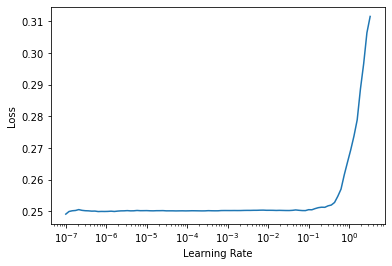

In [166]:
learn.lr_find()

In [168]:
learn.fit_one_cycle(2,5e-3)

epoch,train_loss,valid_loss,time
0,0.237690,0.239454,00:33
1,0.135978,0.234707,00:35


In [162]:
learn.save('./saved_model')

Path('models/saved_model.pth')

In [163]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,488,20092,0,0.663494
1,344,2600,0,0.100883
2,712,19864,1,0.220385
3,661,907,0,0.724480
4,827,28324,1,0.176515
5,123,25084,0,0.243821
6,220,7321,0,0.759690
7,441,25763,0,0.443222
8,481,22016,0,0.963783
